In [44]:
import numpy as np
from matplotlib import pyplot as plt
from geomstats.geometry import special_orthogonal
from scipy.spatial import QhullError
from scipy.interpolate import griddata


def plot_vectors(ax, vectors, color='k.'):
    for vec in range(vectors.shape[1]):
        ax.plot3D(vectors[0,vec], vectors[1,vec], vectors[2,vec], color)

def plot_3d_matrix(ax, mat):
    ii, jj, kk = mat.shape
    for i in range(ii):
        for j in range(jj):
            for k in range(kk):
                if mat[i,j,k].real == 1:
                    ax.plot3D(i, j, k, 'r.')
                if mat[i,j,k].real == 0:
                    ax.plot3D(i, j, k, 'b.')

We begin by defining an xy plane and a test slice. 

These are both simple in this $n=2$ case - what we have is `xy_plane` consisting of vectors to each of the four points in the x,y,z=0 grid of width and height $n=2$. 

Then, we also have `test_slice`, which assigns a value of $1$ to each of those points.

In [9]:
xy_plane = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]])
test_slice = np.array([[1, 1], [1, 1]])

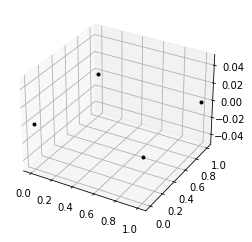

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_vectors(ax, xy_plane.T)
plt.show()

What we want to do is to put this slice into a 3D space - in our case it is convenient to represent this 3D space as an $n\times n\times n$ cube of voxels. For the purposes of `griddata`, we need that cube as a set of vectors pointing to each point (the same as how we represented `xy_plane`). So, we define the $8$ vectors needed and store them in `xyz_cube`.

In [10]:
xyz_cube = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])

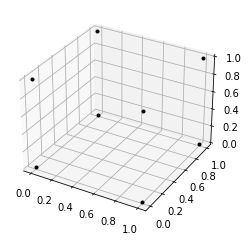

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_vectors(ax, xyz_cube.T)
plt.show()

Now we want to use `griddata` to interpolate this slice. What is happening here is that `griddata` takes the points and values from `xy_plane` and `test_slice` and assumes they are in a 3D space that is otherwise filled with zeroes. Then, it polls each of the points in `xyz_cube` within this space, linearly interpolating their values based on what we inserted via `xy_plane` and `test_slice`. However...

In [42]:
try:
    inserted_slice = griddata(xy_plane, test_slice.reshape((4,)), xyz_cube, fill_value=0).reshape(2, 2, 2)
except QhullError as e:
    print(e)

QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qz Q12 Qt Qc Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1683676233  delaunay  Qz-infinity-point  Q12-allow-wide  Qtriangulate
  Qcoplanar-keep  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  1  Error-roundoff 2e-15  _one-merge 1.8e-14
  Visible-distance 1.2e-14  U-max-coplanar 1.2e-14  Width-outside 2.4e-14
  _wide-facet 7.3e-14  _maxoutside 2.4e-14

precision problems (corrected unless 'Q0' or an error)
      1 degenerate hyperplanes recomputed with gaussian elimination
      1 nearly singular or axis-parallel hyperplanes
      1 zero divisors during back substitute
      2 zero divisors during gaussian elimination

The input to qhull appears to be less than 4 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p3(v5):     1     1     0  0.91
- p4(v4)

Rest assured there's no syntax errors here. The problemn is outlined well by the line: 

```Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)```


What that means is we've inserted a 2D object and expected it to interpolate 3D data. 

Why is this a problem? Let's drop a dimension and give this some thought. We have a line of points in black and we want to interpolate the value of a red point that is near the line:

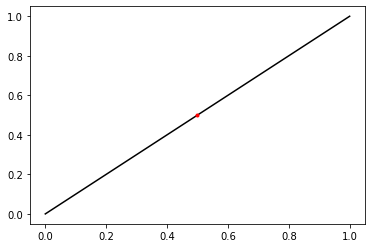

In [35]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0,1)
y = np.linspace(0,1)
plt.plot(x,y,'k-')
plt.plot(0.5,0.5, 'r.')
plt.show()

It's easy for us to say that this point is clearly on the line. And in fact, a computer would probably agree in this case. But, this isn't generally so easy because of **float precision** (or rather a lack thereof). It is entirely reasonable that this point $(0.5,0.5)$ could be represented by the computer as, e.g., $(0.499999999,0.50000001)$. **Is this on the line?**

You might, entirely reasonably, say yes, of course it's on the line. But, unless some tolerance is introduced, the computer would say no this isn't on the line. If we did want tolerance, the actual bounds of the line might look something like:

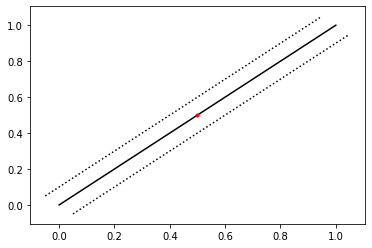

In [36]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0,1)
y = np.linspace(0,1)
plt.plot(x,y,'k-')
plt.plot(x-.05,y+.05, color='black', linestyle='dotted')
plt.plot(x+.05,y-.05, color='black', linestyle='dotted')
plt.plot(0.5,0.5, 'r.')
plt.show()

And anything within the dotted lines is "on" the line. 

The problem we run in to with scipy's `griddata` is that it doesn't put this tolerance here by default. When you give it an underdimensioned object, it just throws an error as it will never interpolate anything to be "in line" with that underdimensioned object. 

We can get around this by adding our own tolerance, in much the same way as I did with those lines above. If we add coordinates to `xy_plane` by copying the plane with some small $z$ difference, say $z \pm 0.05$, then the plane has "bounds" and interpolation will know with confidence what is and isn't on the plane.

In doing this copying, we will also need to copy `test_slice` twice. We assume that `test_slice` values are constant along $z$, as in concept this slice is still 2D. 

In [37]:
z_tolerance = np.array([[0, 0, 0.05],])
xy_plane_tol = np.concatenate((xy_plane + z_tolerance, xy_plane, xy_plane - z_tolerance), axis=0)
test_slice_tiled = np.tile(test_slice, (3,))

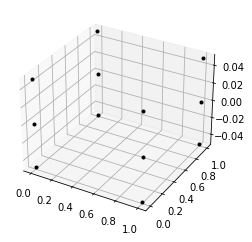

In [38]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_vectors(ax, xy_plane_tol.T)
plt.show()

Do note the scale of the $z$ axis in the plot above. We have `xy_plane` with some very small tolerances in either direction of $z$. Now, when we try the interpolation again:

In [43]:
inserted_slice = griddata(xy_plane_tol, test_slice_tiled.reshape((12,)), xyz_cube, fill_value=0).reshape(2, 2, 2)

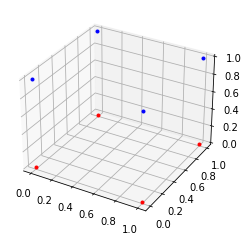

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_3d_matrix(ax, inserted_slice)
plt.show()

Note the red coordinates represent values of $1$ and the blue values of $0$. We have an inserted slice! And no errors popped up, because scipy knew how to handle the "2D" slice when we told it exactly how 2D we wanted that slice to be. 